# Sep 24, 2024: membership entropies [version 2]
membership entropies: weighted resampling

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
import random

import arviz as az

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 10
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'ses'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
def mem_entropy_per_marginal(args, pi):
    # membership entropy per marginal
    ent = stats.entropy(pi, base=2, axis=-1) / np.log2(pi.shape[-1])
    ent = np.round(np.nan_to_num(ent), decimals=3)
    rank_ent = np.round(stats.rankdata(ent) / pi.shape[0], decimals=3)
    return ent, rank_ent

In [6]:
def mem_ent_per_animal(args, df):
    ent = np.stack(df['entropy'].to_list(), axis=-1) @ df['omega'].to_numpy()
    ent = np.round(ent, decimals=3)
    rank_ent = np.stack(df['rank-entropy'].to_list(), axis=-1) @ df['omega'].to_numpy()
    rank_ent = np.round(rank_ent, decimals=3)
    return ent, rank_ent

def stats_per_animal(args, df, level=-1):
    ent, rank_ent = mem_ent_per_animal(args, df)
    
    stats_df = pd.DataFrame({})
    stats_df['sub'] = [df.iloc[0]['sub']]
    if level != -1: stats_df['level'] = [level]
    stats_df['entropy'] = [ent]
    stats_df['rank-entropy'] = [rank_ent]

    return stats_df

In [7]:
def stats_all_animals(args, indiv_files):
    stats_dfs = []
    for indiv_file in indiv_files[:]:
        with open(indiv_file, 'rb') as f:
            indiv_marginals_df = pickle.load(f)
        
        indiv_marginals_df['pi'] = indiv_marginals_df['pi'].apply(lambda pi: np.round(pi, decimals=3))
        indiv_marginals_df[['entropy', 'rank-entropy']] = indiv_marginals_df['pi'].apply(lambda pi: pd.Series(mem_entropy_per_marginal(args, pi)))

        if args.sbm in ['a', 'd', 'o']:
            df = indiv_marginals_df
            stats_df = stats_per_animal(args, df)
            stats_dfs += [stats_df]

        if args.sbm in ['h']:
            for level in indiv_marginals_df['level'].unique()[:]:
                df = indiv_marginals_df[indiv_marginals_df['level'] == level]
                stats_df = stats_per_animal(args, df, level)
                stats_dfs += [stats_df]

    stats_dfs = pd.concat(stats_dfs).reset_index(drop=True)
    return stats_dfs

In [8]:
def bootstrap_histogram_means(matrix, n_bootstrap=1000, confidence_level=0.95):
    n_realizations, n_bins = matrix.shape
    
    compute_sample_mean = lambda x: np.mean(x, axis=0)
    
    # bootstrap
    bootstrap_means = np.array([
        compute_sample_mean(matrix[np.random.choice(n_realizations, size=n_realizations, replace=True), :])
        for _ in range(n_bootstrap)
    ])
    
    # statistics
    mean_estimate = np.mean(bootstrap_means, axis=0)
    
    # confidence intervals
    # in case of bootstrapping, one can calculate CI as follows:
    # sort all bootstrap means in ascending order 
    # lower bound = confidence_level / 2 th percentile of the bootstrap means
    # upper bound = 100 - confidence_level / 2 th percentile of the bootstrap means
    ci_lower = np.percentile(bootstrap_means, q=100*(1 - confidence_level) / 2, axis=0)
    ci_upper = np.percentile(bootstrap_means, q=100 * (1 - (1 - confidence_level) / 2), axis=0)
    # 95% CI based on standard error of the mean
    # vs
    # 95% CI based on standard deviation of data
    
    return mean_estimate, ci_lower, ci_upper

In [9]:
def plot_entropies(args, ents_dfs, column='rank-entropy'):
    X = np.stack(ents_dfs[column].to_list(), axis=0)

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 50), dpi=90)
    ax = axs
    sns.stripplot(
        X, 
        ax=ax, 
        orient='h', 
        jitter=False, 
        size=4, 
        color='grey'
    )
    sns.boxplot(
        X, 
        ax=ax, 
        orient='h', 
        fill=False, 
        width=0.5, 
        fliersize=0.0, 
        color='black', 
        medianprops={"color": "tab:red", "linewidth": 2}, 
        showcaps=False
    )
    ymin, ymax = ax.get_ylim()
    ax.axvline(x=0.25, ymin=ymin, ymax=ymax, color='lightsteelblue', linestyle='--', linewidth=2)
    ax.axvline(x=0.50, ymin=ymin, ymax=ymax, color='lightsteelblue', linestyle='--', linewidth=2)
    ax.axvline(x=0.75, ymin=ymin, ymax=ymax, color='lightsteelblue', linestyle='--', linewidth=2)

    title = '\n'.join([f'{SBM}', f'{args.stats_column}'])
    ax.set(
        xlabel='entropy', 
        ylabel='roi', 
        title=title,
        xlim=[0, 1],
    )
    return fig

def plot_nested_entropies(args, ents_dfs, column='rank-entropy'):
    ncols = 5
    nrows = int(np.ceil(len(ents_dfs['level'].unique()) / ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 50*nrows), dpi=90)
    fig.tight_layout(h_pad=3, w_pad=3)

    for level in ents_dfs['level'].unique():
        row, col = level // ncols, level % ncols
        ax = axs[row, col] if nrows > 1 else axs[col]

        X = np.stack(ents_dfs[ents_dfs['level'] == level][column].to_list(), axis=0)
        sns.stripplot(
            X, 
            ax=ax, 
            orient='h', 
            jitter=False, 
            size=4, 
            color='grey'
        )
        sns.boxplot(
            X, 
            ax=ax, 
            orient='h', 
            fill=False, 
            width=0.5, 
            fliersize=0.0, 
            color='black', 
            medianprops={"color": "tab:red", "linewidth": 2}, 
            showcaps=False
        )
        ymin, ymax = ax.get_ylim()
        ax.axvline(x=0.25, ymin=ymin, ymax=ymax, color='lightsteelblue', linestyle='--', linewidth=2)
        ax.axvline(x=0.50, ymin=ymin, ymax=ymax, color='lightsteelblue', linestyle='--', linewidth=2)
        ax.axvline(x=0.75, ymin=ymin, ymax=ymax, color='lightsteelblue', linestyle='--', linewidth=2)

        if (row, col) == (0, 0):
            title = '\n'.join([f'{SBM}_level-{level}', f'{args.stats_column}'])
        else:
            title = '\n'.join([f'{SBM}_level-{level}', f' '])
        ax.set(
            xlabel='entropy', 
            ylabel='roi', 
            title=title,
            xlim=[0, 1],
        )
    
    for c in range(col+1, ncols):
        ax = axs[row, c] if nrows > 1 else axs[c]
        fig.delaxes(ax)
    
    return fig

In [10]:
sbms_list = [
    (True, 'a'),
    (True, 'd'),
    (True, 'h'),
    (False, 'd'),
    (False, 'h'),
]

sbm--a


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm--a/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm--a/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-10/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm--a/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/gr

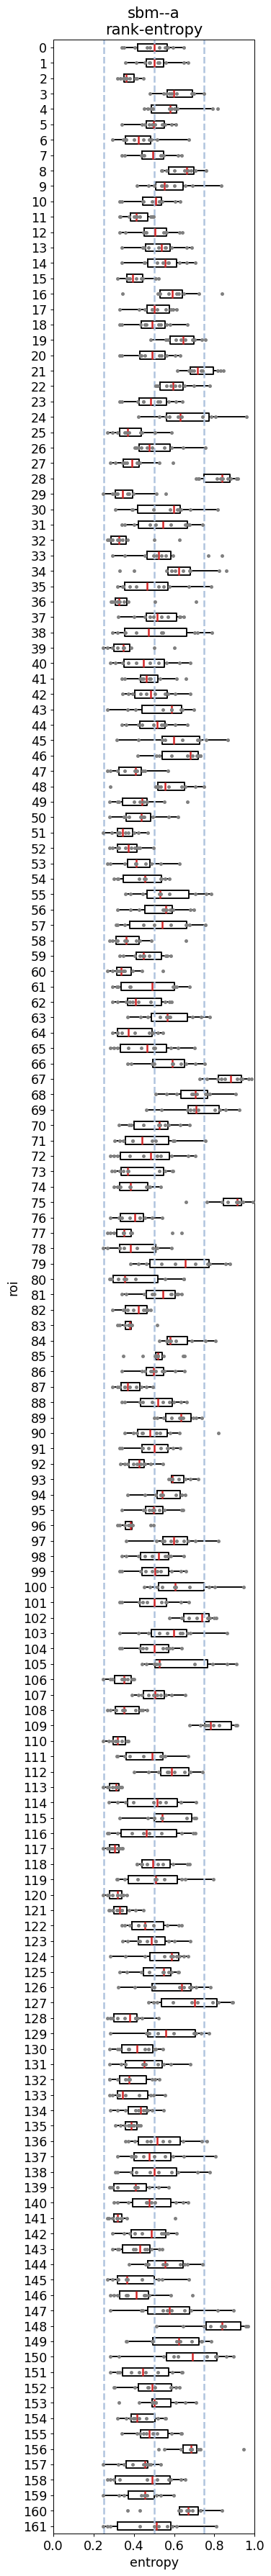

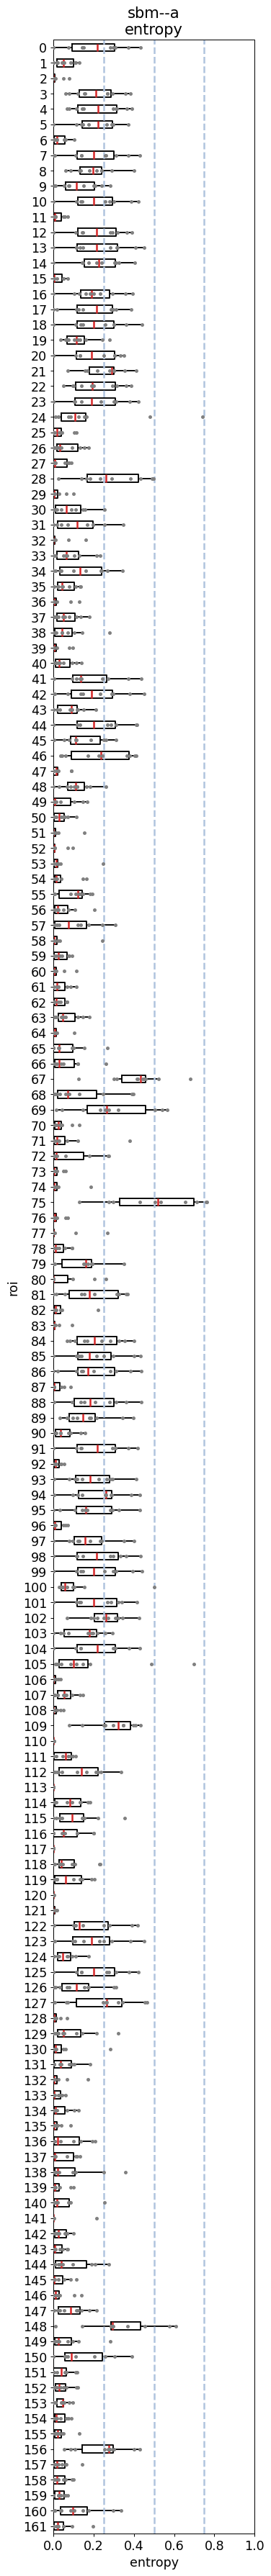

In [11]:
for sbm in sbms_list[:1]:
    args.dc, args.sbm = sbm

    args.nested = args.sbm == 'h'

    args.force_niter = 40000
    args.num_draws = int((1/2) * args.force_niter)

    def sbm_name(args):
        dc = f'dc' if args.dc else f'nd'
        dc = f'' if args.sbm in ['a'] else dc
        file = f'sbm-{dc}-{args.sbm}'
        return file

    SBM = sbm_name(args)
    print(SBM)

    indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-marginals-df.pkl', recursive=True))
    display(indiv_files)

    args.thresh = 0.1
    args.binwidth = 0.25
    stats_dfs = stats_all_animals(args, indiv_files)

    for column in ['rank-entropy', 'entropy']:
        args.stats_column = column
        ent_folder = f'{ESTIM_path}/group/membership-entropies/{args.stats_column}/{SBM}'
        os.system(f'mkdir -p {ent_folder}')

        if args.sbm in ['a', 'd', 'o']:
            fig = plot_entropies(args, stats_dfs, column=column)
            fig.savefig(f'{ent_folder}/desc-{column}.pdf')
            
        if args.sbm in ['h']:
            for level in stats_dfs.level.unique():
                fig = plot_nested_entropies(args, stats_dfs, column=column)
            fig.savefig(f'{ent_folder}/desc-{column}.pdf')
        